# Week 7a: Partial Differential Equations

## Computational Modelling Process

The computational modeling process involves three main steps:
1. **Model Development:** Create a mathematical model of a real system, simplifying complexities and making assumptions (e.g., ignoring air friction for a falling object).

2. **Equation Formation:** Express the system's behaviour using mathematical equations (ODEs/PDEs), which are often difficult to solve analytically.

3. **Solving the Equations:**
- **Analytical Solution** (if possible): Solve equations exactly using mathematical techniques.
- **Numerical Solution** (more common): Use computational methods and algorithms to approximate solutions.

## Differential Equations

- Many problems in physics and engineering can be expressed using **ordinary differential equations (ODEs)** or **partial differential equations (PDEs)**.
- Mathematical descriptions of complex problems often simplify significantly by considering **infinitesimal changes** in variables, leading to the formation of differential equations.

## ODEs vs PDEs

### Ordinary Differential Equations (ODEs)

- **Single independent variable** (often time, sometimes a spatial position)
- One or more dependent variables
- **Ordinary** (not partial) derivatives
- The solution set has **finite dimension**
- **Example**: Equations governing free fall can yield analytic solutions in closed form using known functions.

### Partial Differential Equations (PDEs)

- **Multiple independent variables**
- One or more dependent variables
- **Partial derivatives**
- Can sometimes be reduced to systems of ODEs
- The solution set has **infinite dimension**
- Common in fluid dynamics, heat transfer, and other fields
- Show up in a lot of physics areas!

## Types of PDEs

The solution method depends on the type of PDE:

### 1. Parabolic PDEs
Examples: diffusion, time-dependent Schrödinger equation

$$\frac{\partial T(x,t)}{\partial t} = \kappa \frac{\partial^2 T(x,t)}{\partial x^2}$$

### 2. Hyperbolic PDEs
Examples: wave equation

$$\frac{\partial^2 A(x,t)}{\partial t^2} = c^2 \frac{\partial^2 A(x,t)}{\partial x^2}$$

### 3. Elliptic PDEs
Examples: Poisson/Laplace equation

$$\frac{\partial^2 \Phi}{\partial x^2} + \frac{\partial^2 \Phi}{\partial y^2} = -\frac{1}{\epsilon_0}\rho(x,y)$$

## Explicit vs Implicit Methods

### Explicit Methods

- The future value of the function is determined **explicitly** from the current value
- FTCS and other "marching methods": start from initial conditions & compute solutions into the future, 1 step at a time (Chapter 6)
- Lax & Lax-Wendroff methods (Chapter 7)
- **Can be numerically unstable**

### Implicit Methods

- The future value of the function affects the current value (Chapter 9)
- Involves a matrix inversion
- **Unconditionally stable** (but can still be incorrect!)

## Python Packages for PDEs

There are many Python packages available for solving PDEs:

- **PyPDE**: "a Python package for solving PDEs" https://pypi.org/project/py-pde/
- **FiPy**: "an object oriented, PDE solver, written in Python, based on a standard finite volume approach" https://www.ctcms.nist.gov/fipy/
- **SfePy**: "software for solving systems of coupled PDEs by the finite element method in 1D, 2D and 3D" http://sfepy.org/doc-devel/index.html
- **FEniCS**: "a popular open-source (LGPLv3) computing platform for solving PDEs" https://fenicsproject.org/
- **PyDEns**: "a framework for solving ODEs & PDEs using neural networks" https://pypi.org/project/pydens/

In [21]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## Diffusion & FTCS (Forward Time Centered Space) Method

The **diffusion equation** is a partial differential equation (PDE) that describes how heat diffuses through a medium over time.

### The 1D Diffusion Equation

$$\frac{\partial T(x,t)}{\partial t} = \kappa \frac{\partial^2 T(x,t)}{\partial x^2}$$

where:
- $T$ = temperature in a one-dimensional bar, at position $x$ and time $t$
- $\kappa$ = thermal diffusion coefficient (constant)

### Physical Setup

Consider a 1D bar extending from $x = -L/2$ to $x = +L/2$:

```
x = -L/2        x=0          x = +L/2
|---------------|-------------|
```

## FTCS Method Implementation

The FTCS (Forward Time Centered Space) method is a finite difference method used to numerically solve the diffusion equation or similar parabolic partial differential equations.

### Discretization

**Divide time and space into grid points:**

1. **Spatial discretization:**
   - $h = L/(N-1) \Rightarrow x_i = ih - \frac{L}{2}$
   - $h$ is the spatial step (grid) size
   - $i$ is the index of the position along the grid

2. **Temporal discretization:**
   - $t_n = n\tau$
   - $\tau$ is the time step size
   - Total timesteps are divided to $n$ steps

3. **Notation:**
   - Denote temperature at position $x_i$ and time $t_n$ as $T_i^n = T(x_i, t_n)$

### Finite Difference Approximations

#### Time Derivative (Forward Difference)

$$\frac{\partial T}{\partial t} = \frac{T_i^{n+1} - T_i^n}{\tau}$$

This is the **Forward Time** part of FTCS.

#### Space Derivative (Centered Difference)

$$\frac{\partial^2 T}{\partial x^2} = \frac{T_{i+1}^n + T_{i-1}^n - 2T_i^n}{h^2}$$

This is the **Centered Space** part of FTCS.

### FTCS Update Equation

Substituting the finite difference approximations into the diffusion equation and rearranging:

$$T_i^{n+1} = T_i^n + \frac{\kappa\tau}{h^2}\left(T_{i+1}^n + T_{i-1}^n - 2T_i^n\right)$$

This equation allows us to compute the temperature at the next time step ($n+1$) based on the current time step ($n$).

### Stability Criterion

For numerical stability, the FTCS method requires:

$$\tau \leq \frac{1}{2}\frac{h^2}{\kappa}$$

**Important:** If this condition is violated, the solution will become numerically unstable and blow up!

### Boundary Conditions

Boundary conditions must be specified to solve the diffusion equation. Common boundary conditions include:

1. **Dirichlet Boundary Conditions**: Fixed temperature at the boundaries
   - Example: $T(x=-L/2, t) = T_L$ and $T(x=+L/2, t) = T_R$

2. **Neumann Boundary Conditions**: Fixed heat flux at the boundaries
   - Example: $\frac{\partial T}{\partial x}\bigg|_{x=-L/2} = 0$ (insulated boundary)

## FTCS Implementation: dftcs.py

Here's a complete implementation that solves the diffusion equation using the FTCS scheme with a **delta function** initial condition. This demonstrates how heat diffuses from a point source.

In [22]:
# dftcs - Program to solve the diffusion equation 
# using the Forward Time Centered Space (FTCS) scheme.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Initialize parameters (time step, grid spacing, etc.)
tau = 0.0001      # Time step
N = 61            # Number of grid points
L = 1.            # The system extends from x=-L/2 to x=L/2
h = L/(N-1)       # Grid size
kappa = 1.        # Diffusion coefficient
coeff = kappa*tau/h**2

print(f"Grid spacing h = {h:.6f}")
print(f"Time step tau = {tau:.6f}")
print(f"Coefficient = {coeff:.6f}")
print(f"Stability limit = 0.5")

if coeff < 0.5:
    print('✓ Solution is expected to be stable')
else:
    print('WARNING: Solution is expected to be unstable')

# Set initial and boundary conditions
tt = np.zeros(N)                # Initialize temperature to zero at all points
tt[int(N/2)] = 1./h             # Initial cond. is delta function in center
# The boundary conditions are tt[0] = tt[N-1] = 0

# Set up loop and plot variables
xplot = np.arange(N)*h - L/2.    # Record the x scale for plots
iplot = 0                        # Counter used to count plots
nstep = 300                      # Maximum number of iterations
nplots = 50                      # Number of snapshots (plots) to take
plot_step = nstep/nplots         # Number of time steps between plots

# Loop over the desired number of time steps
ttplot = np.empty((N, nplots))
tplot = np.empty(nplots)

for istep in range(nstep):  ## MAIN LOOP ##
    
    # Compute new temperature using FTCS scheme
    tt[1:(N-1)] = (tt[1:(N-1)] + 
                   coeff*(tt[2:N] + tt[0:(N-2)] - 2*tt[1:(N-1)]))
    
    # Periodically record temperature for plotting
    if (istep+1) % plot_step < 1:         # Every plot_step steps
        ttplot[:, iplot] = np.copy(tt)    # record tt(i) for plotting
        tplot[iplot] = (istep+1)*tau      # Record time for plots
        iplot += 1

print(f"\nSimulation complete! Ran {nstep} time steps.")
print(f"Total time simulated: {nstep*tau:.6f}")

Grid spacing h = 0.016667
Time step tau = 0.000100
Coefficient = 0.360000
Stability limit = 0.5
✓ Solution is expected to be stable

Simulation complete! Ran 300 time steps.
Total time simulated: 0.030000


### Visualizing the Results: 3D Surface Plot

This shows how the temperature evolves in both space and time as a 3D surface.

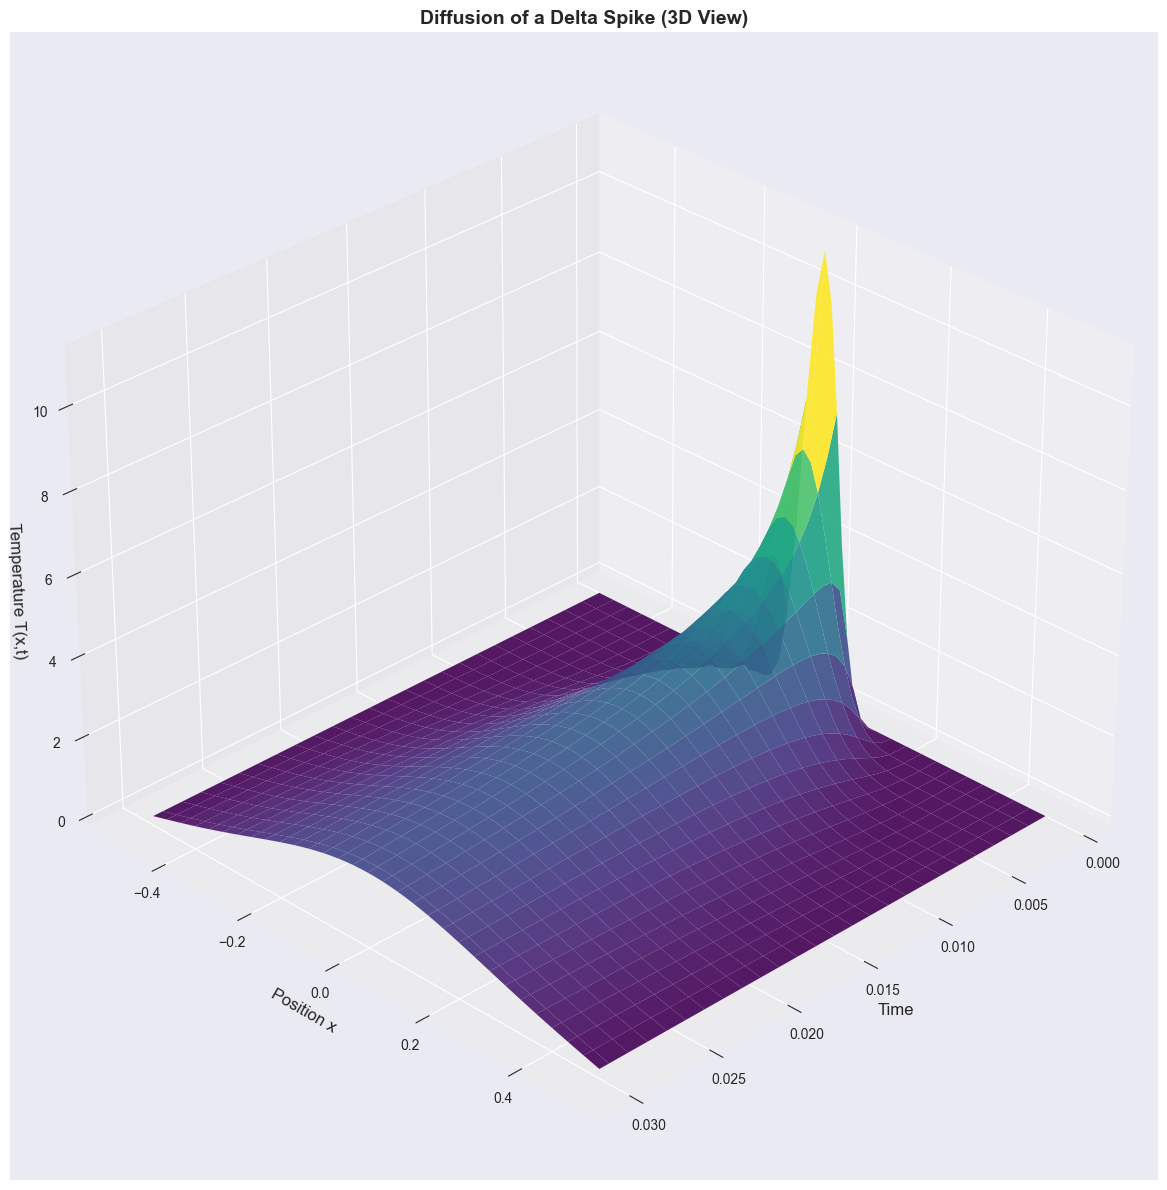

In [30]:
# Plot temperature versus x and t as a wire-mesh plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

Tp, Xp = np.meshgrid(tplot, xplot)
ax.plot_surface(Tp, Xp, ttplot, rstride=2, cstride=2, cmap=cm.viridis, alpha=0.9)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Position x', fontsize=12)
ax.set_zlabel('Temperature T(x,t)', fontsize=12)
ax.set_title('Diffusion of a Delta Spike (3D View)', fontsize=14, fontweight='bold')
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

### Visualizing the Results: Contour Plot

A contour plot provides a top-down view showing lines of constant temperature.

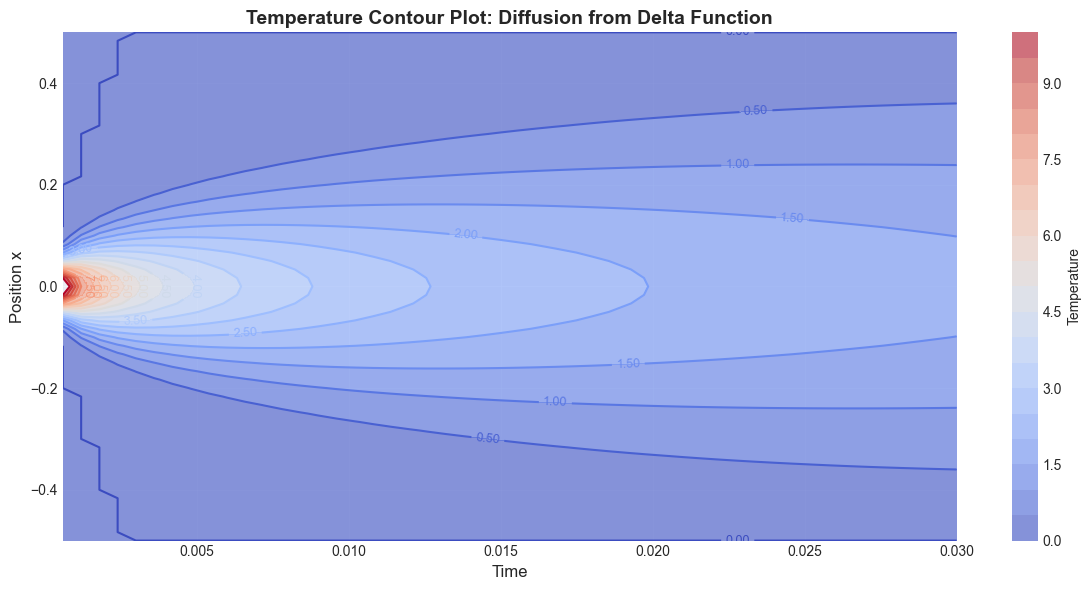

In [24]:
# Plot temperature versus x and t as a contour plot
fig, ax = plt.subplots(figsize=(12, 6))

levels = np.linspace(0., 10., num=21) 
ct = ax.contour(tplot, xplot, ttplot, levels=levels, cmap='coolwarm') 
ax.clabel(ct, fmt='%1.2f', fontsize=9)

# Add filled contours for better visualization
cf = ax.contourf(tplot, xplot, ttplot, levels=levels, cmap='coolwarm', alpha=0.6)
plt.colorbar(cf, ax=ax, label='Temperature')

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Position x', fontsize=12)
ax.set_title('Temperature Contour Plot: Diffusion from Delta Function', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Understanding the Delta Function Initial Condition

The delta function initial condition represents:
- An infinitely sharp spike of heat at the center
- In the discrete case: `tt[N/2] = 1/h` (all other points = 0)
- The normalization by `1/h` ensures the total heat is constant

**Physical interpretation**: Like placing a very hot, infinitesimally thin wire at the center of a cold bar.

**What we observe**:
1. The spike immediately starts spreading
2. Height decreases while width increases
3. The solution approaches a Gaussian shape
4. Total "area under curve" (heat) is conserved

## Key Observations from dftcs.py

### 1. **Vectorized Implementation**
```python
tt[1:(N-1)] = tt[1:(N-1)] + coeff*(tt[2:N] + tt[0:(N-2)] - 2*tt[1:(N-1)])
```
This efficiently updates all interior points at once using NumPy array slicing.

### 2. **Delta Function Normalization**
```python
tt[int(N/2)] = 1./ h
```
The factor `1/h` ensures proper normalization as the grid is refined.

### 3. **Zero Boundary Conditions**
The edges remain at zero temperature throughout (Dirichlet boundary conditions).

### 4. **Stability Check**
The code checks if `coeff = κτ/h² < 0.5` to warn about potential instability.

### 5. **Conservation of Heat**
The total integral under the curve should remain constant (conservation of energy).

## Summary

In this lecture, we covered:

1. **Computational Modeling Process**: Model development, equation formation, and numerical solution
2. **ODEs vs PDEs**: Key differences and applications
3. **Types of PDEs**: Parabolic, hyperbolic, and elliptic
4. **Explicit vs Implicit Methods**: Advantages and disadvantages
5. **FTCS Method**: Implementation for the 1D diffusion equation
6. **Stability Analysis**: Critical importance of the stability criterion
7. **Boundary Conditions**: Dirichlet and Neumann conditions